In [34]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
import pandas as pd

df = pd.read_csv('./network_backup_dataset.csv')
df_group = df.groupby([df.columns[0], df.columns[1], df.columns[3]], sort=False).sum().iloc[:,1:2]

In [36]:
import calendar
days = dict(zip(calendar.day_name,range(1,8)))

df.drop('Backup Time (hour)', axis=1, inplace=True)
df['Day of Week'] = df['Day of Week'].apply(lambda s: days[s])

f = lambda s: int(s[s.rindex('_')+1:])

df['Work-Flow-ID'] = df['Work-Flow-ID'].apply(f)
df['File Name'] = df['File Name'].apply(f)

In [37]:
Xs = df.ix[:, [0, 1, 2, 3, 4]].values
ys = df.ix[:, 5].values
print Xs
print ys

[[ 1  1  1  0  0]
 [ 1  1  1  2 12]
 [ 1  1  1  2 13]
 ...
 [15  7 21  4 26]
 [15  7 21  4 25]
 [15  7 21  4 24]]
[0.         0.         0.         ... 0.19857244 0.19957007 0.20120052]


In [38]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt
def cv_random_forest(model, X, y):
    kf = KFold(n_splits=10)
    rmse_train, rmse_test = 0, 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        rmse_train += mean_squared_error(y_train, model.predict(X_train))
        rmse_test += mean_squared_error(y_test, model.predict(X_test))

    return sqrt(rmse_train / 10), sqrt(rmse_test / 10)

In [40]:
# Question 2b (i)
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators=20, max_features=5, max_depth=4, bootstrap=True, oob_score=True)
rmse_train, rmse_test = cv_random_forest(regr, Xs, ys)
print "Training RMSE:", rmse_train
print "Testing RMSE:", rmse_test
print "oob score:", regr.oob_score_

Training RMSE: 0.0606594152194
Testing RMSE: 0.0607409756089
oob score: 0.6509845906050806


In [45]:
import plotly.offline as py
import plotly.graph_objs as go
def draw_curve(x, y, name, title='', xlabel='', ylabel=''):
    data = []
    width, height = 800, 600
    
    if type(name) != list or len(name) == 1:
        width, height = 600, 450
        trace1 = go.Scatter(x=x, y=y, 
                            mode='lines', 
                            line=dict(color='darkorange', width=2),
                            name=name
                           )
        data.append(trace1)
    else:
        for i in range(len(name)):
            trace1 = go.Scatter(x=x[i], y=y[i], 
                                mode='lines', 
                                line=dict(width=2),
                                name=name[i]
                               )
            data.append(trace1)
    
    layout = go.Layout(title=title,
                       autosize=False,
                       width=width,
                       height=height,
                       xaxis=dict(title=xlabel, ticks='outside', mirror=True, linewidth=1),
                       yaxis=dict(title=ylabel, ticks='outside', mirror=True, linewidth=1),
                       legend=dict(x=.5, y=.2, bordercolor='#D3D3D3', borderwidth=1))
    
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [49]:
# Question 2b (ii)
import matplotlib.pyplot as plt
oob_scores_features = []
rmse_tests_features = []
featureRange = range(1, 6)
numTreeRange = range(1, 201)
for maxNumFeatures in featureRange:
    oob_scores = []
    rmse_tests = []
    for numTree in numTreeRange:
        regr = RandomForestRegressor(n_estimators=numTree, max_features=maxNumFeatures, max_depth=4, bootstrap=True, oob_score=True)
        rmse_train, rmse_test = cv_random_forest(regr, Xs, ys)
        oob_scores.append(regr.oob_score_)
        rmse_tests.append(rmse_test)
    print "Progress at max feature = %d" % maxNumFeatures
    oob_scores_features.append(oob_scores)
    rmse_tests_features.append(rmse_tests)
oob_scores_names = ['max number of features = %d' % x for x in featureRange]

Progress at max feature = 1
Progress at max feature = 2
Progress at max feature = 3
Progress at max feature = 4
Progress at max feature = 5


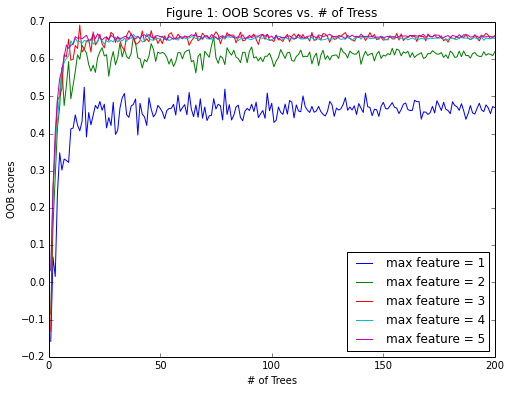

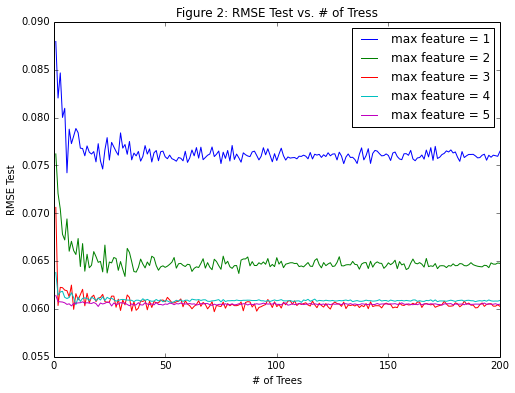

In [84]:
plt.figure(figsize=(8,6))
plt.plot(numTreeRange, oob_scores_features[0], numTreeRange, oob_scores_features[1], numTreeRange, oob_scores_features[2],numTreeRange, oob_scores_features[3],numTreeRange, oob_scores_features[4])
plt.legend(['max feature = 1', 'max feature = 2', 'max feature = 3', 'max feature = 4', 'max feature = 5'], loc='lower right')
plt.xlabel('# of Trees')
plt.ylabel('OOB scores')
plt.title('Figure 1: OOB Scores vs. # of Tress')
plt.show()
plt.figure(figsize=(8,6))
plt.plot(numTreeRange, rmse_tests_features[0], numTreeRange, rmse_tests_features[1], numTreeRange, rmse_tests_features[2],numTreeRange, rmse_tests_features[3],numTreeRange, rmse_tests_features[4])
plt.legend(['max feature = 1', 'max feature = 2', 'max feature = 3', 'max feature = 4', 'max feature = 5'], loc='top right')
plt.xlabel('# of Trees')
plt.ylabel('RMSE Test')
plt.title('Figure 2: RMSE Test vs. # of Tress')
plt.show()

In [98]:
max_oob_score, max_oob_score_index = max((x, (i, j)) for i, row in enumerate(oob_scores_features) for j, x in enumerate(row))
print max_oob_score, "at max feature =", max_oob_score_index[0] + 1, "and # of Trees =", max_oob_score_index[1] + 1

0.6919621824628408 at max feature = 3 and # of Trees = 14


In [99]:
min_RMSE, min_RMSE_index = min((x, (i, j)) for i, row in enumerate(rmse_tests_features) for j, x in enumerate(row))
print min_RMSE, "at max feature =", min_RMSE_index[0] + 1, "and # of Trees =", min_RMSE_index[1] + 1

0.059716145278 at max feature = 3 and # of Trees = 72


In [100]:
best_max_feature = 3
best_num_tree_range = range(10, 101)
oob_scores_depth = []
rmse_tests_depth = []
tree_depth = range(10, 16)
for depth in tree_depth:
    oob_scores = []
    rmse_tests = []
    for numTree in best_num_tree_range:
            regr = RandomForestRegressor(n_estimators=numTree, max_features=best_max_feature, max_depth=depth, bootstrap=True, oob_score=True)
            rmse_train, rmse_test = cv_random_forest(regr, Xs, ys)
            oob_scores.append(regr.oob_score_)
            rmse_tests.append(rmse_test)
    oob_scores_depth.append(oob_scores)
    rmse_tests_depth.append(rmse_tests)
    print "Progress at tree depth = %d" % depth

Progress at tree depth = 10
Progress at tree depth = 11
Progress at tree depth = 12
Progress at tree depth = 13
Progress at tree depth = 14
Progress at tree depth = 15


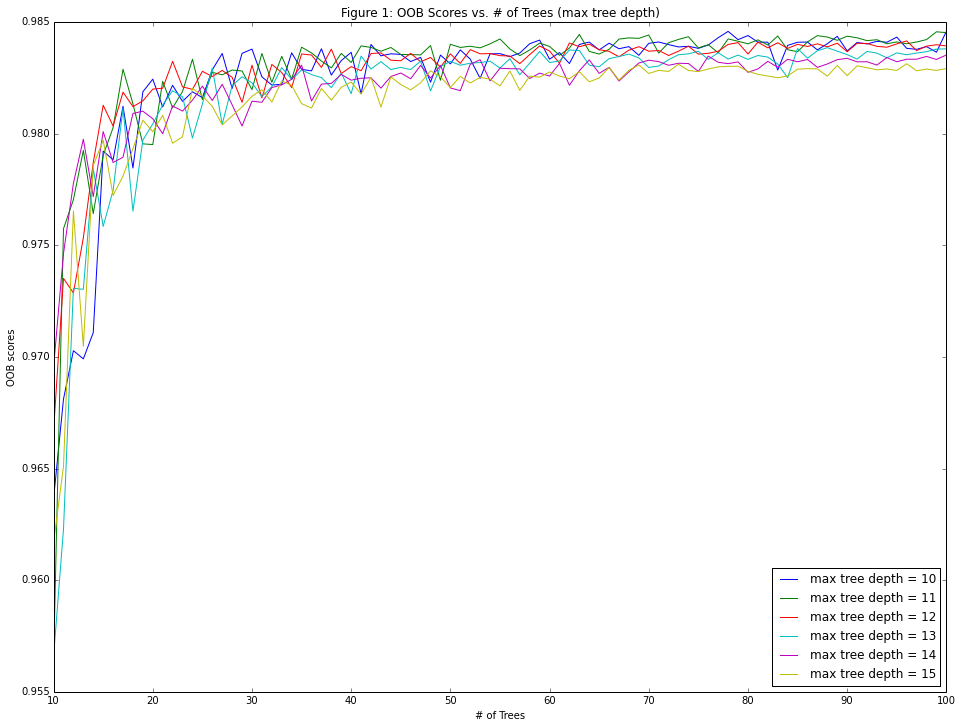

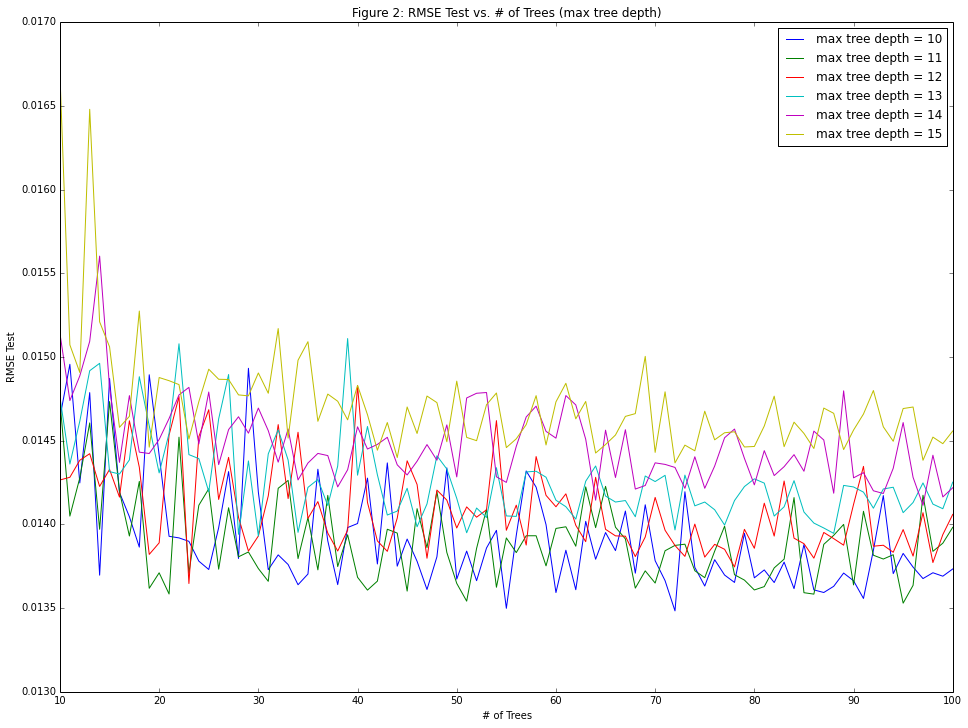

In [101]:
plt.figure(figsize=(16,12))
plt.plot(best_num_tree_range, oob_scores_depth[0], best_num_tree_range, oob_scores_depth[1], best_num_tree_range, oob_scores_depth[2],best_num_tree_range, oob_scores_depth[3],best_num_tree_range, oob_scores_depth[4], best_num_tree_range, oob_scores_depth[5])
plt.legend(['max tree depth = 10', 'max tree depth = 11', 'max tree depth = 12', 'max tree depth = 13', 'max tree depth = 14', 'max tree depth = 15'], loc='lower right')
plt.xlabel('# of Trees')
plt.ylabel('OOB scores')
plt.title('Figure 1: OOB Scores vs. # of Trees (max tree depth)')
plt.show()
plt.figure(figsize=(16,12))
plt.plot(best_num_tree_range, rmse_tests_depth[0], best_num_tree_range, rmse_tests_depth[1], best_num_tree_range, rmse_tests_depth[2],best_num_tree_range, rmse_tests_depth[3],best_num_tree_range, rmse_tests_depth[4], best_num_tree_range, rmse_tests_depth[5])
plt.legend(['max tree depth = 10', 'max tree depth = 11', 'max tree depth = 12', 'max tree depth = 13', 'max tree depth = 14', 'max tree depth = 15'], loc='top right')
plt.xlabel('# of Trees')
plt.ylabel('RMSE Test')
plt.title('Figure 2: RMSE Test vs. # of Trees (max tree depth)')
plt.show()

In [116]:
max_oob_score, max_oob_score_index = max((x, (i, j)) for i, row in enumerate(oob_scores_depth) for j, x in enumerate(row))
print max_oob_score, "at max tree depth =", max_oob_score_index[0]+10, "and # of Trees =", max_oob_score_index[1] + 10

0.9845909887093068 at max tree depth = 10 and # of Trees = 100


In [117]:
min_RMSE, min_RMSE_index = max((x, (i, j)) for i, row in enumerate(rmse_tests_depth) for j, x in enumerate(row))
print min_RMSE, "at max tree depth =", min_RMSE_index[0] + 10, "and # of Trees =", min_RMSE_index[1] + 10

0.016688134051 at max tree depth = 15 and # of Trees = 10


In [126]:
best_num_tree = 90
best_max_feature = 3
best_max_depth = 15
bestRFModel = RandomForestRegressor(n_estimators=best_num_tree, max_features=best_max_feature, max_depth=best_max_depth, bootstrap=True, oob_score=True)
rmse_train, rmse_test = cv_random_forest(bestRFModel, Xs, ys)
print "Test RMSE is", rmse_test
print "Feature importances:", bestRFModel.feature_importances_

Test RMSE is 0.0143772926689
Feature importances: [0.0083868  0.298829   0.3455059  0.15041941 0.19685888]


In [125]:
from sklearn import tree
tree.export_graphviz(bestRFModel.estimators_[0], out_file='bestRF.dot', max_depth=4)

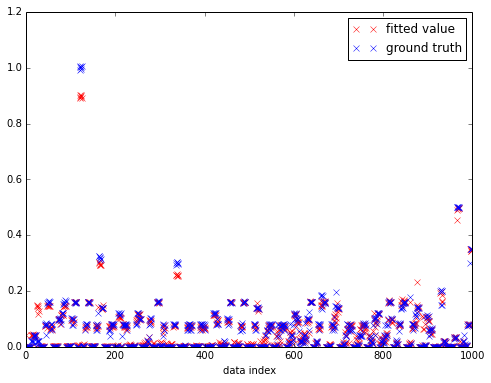

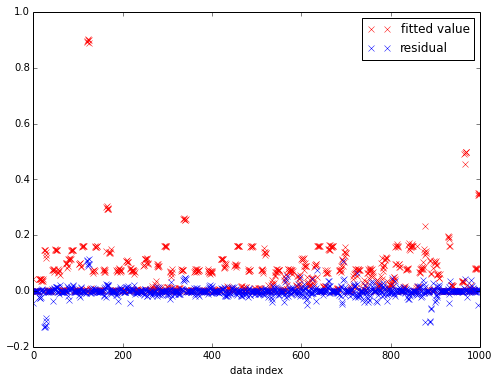

In [129]:
kf = KFold(n_splits=10)
allpre_res = [None for i in range(len(df))]
for train_index, test_index in kf.split(Xs):
    X_train, X_test = Xs[train_index], Xs[test_index]
    y_train, y_test = ys[train_index], ys[test_index]
    bestRFModel.fit(X_train, y_train)
    train_pred_y = bestRFModel.predict(X_train)
    test_pred_y = bestRFModel.predict(X_test)
    for i in range(len(test_index)):
        allpre_res[test_index[i]] = test_pred_y[i]

def two_plots(allpre_res, pre_gt):
    x = range(0, 1000)
    y1 = allpre_res 
    y2 = pre_gt  
    residual = pre_gt - allpre_res
    y3 = residual

    # show basic model plot
    # fitted value & ground truth
    # only plot the first 1000 data points and results we get.
    # blue 'x' is gt, while red 'x' is fitted value
    fig = plt.figure()
    plt.figure(figsize=(8,6))
    l1, = plt.plot(x, y1[0:1000], 'rx', label='fitted value')
    l2, = plt.plot(x, y2[0:1000], 'bx', label='ground truth')
    plt.legend(loc='upper right')
    plt.xlabel('data index')
    plt.show()

    # fitted value & residual
    fig = plt.figure()
    plt.figure(figsize=(8,6))
    l1, = plt.plot(x, y1[0:1000], 'rx', label='fitted value')
    l2, = plt.plot(x, y3[0:1000], 'bx', label='residual')
    plt.legend(loc='upper right')
    plt.xlabel('data index')
    plt.show()

two_plots(allpre_res, ys)